In [ ]:
!pip install yfinance prophet pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 40 kB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 199 kB 75.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=df8ac9c6f3ce2d8eca22a403dfe15147ac373bf4f05869debd53cb9026a23a57
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# Data processing
import pandas as pd
import numpy as np

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

# Process bar
from tqdm import tqdm

# Tracking time
from time import time

In [ ]:
# Data start date
start_date = '2020-01-02'

# Data end date
end_date = '2022-01-01'

In [ ]:
# Download data
ticker_list = ['TSLA', 'GOOG', 'ORCL', 'MSFT', 'AMZN']

data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Drop the top level column name
data.columns = data.columns.droplevel()

# Take a look at the data
data.head()

[*********************100%***********************]  5 of 5 completed


AMZN       GOOG        MSFT       ORCL       TSLA
Date                                                              
2020-01-02  94.900497  68.368500  160.619995  53.950001  28.684000
2020-01-03  93.748497  68.032997  158.619995  53.759998  29.534000
2020-01-06  95.143997  69.710503  159.029999  54.040001  30.102667
2020-01-07  95.343002  69.667000  157.580002  54.160000  31.270666
2020-01-08  94.598503  70.216003  160.089996  54.130001  32.809334

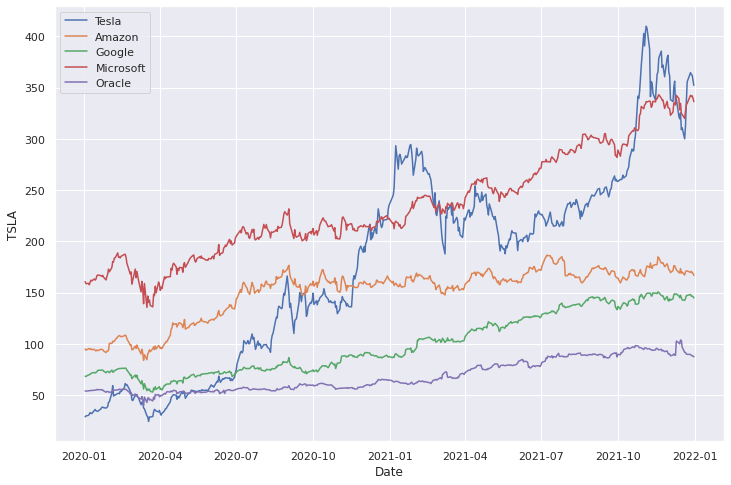

In [ ]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['TSLA'])
sns.lineplot(x=data.index, y=data['AMZN'])
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['MSFT'])
sns.lineplot(x=data.index, y=data['ORCL'])
plt.legend(labels = ['Tesla', 'Amazon', 'Google', 'Microsoft', 'Oracle'])

In [ ]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2020-01-02 to 2021-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMZN    505 non-null    float64
 1   GOOG    505 non-null    float64
 2   MSFT    505 non-null    float64
 3   ORCL    505 non-null    float64
 4   TSLA    505 non-null    float64
dtypes: float64(5)
memory usage: 23.7 KB


In [ ]:
# Release Date from the index
data = data.reset_index()

# Change data from the wide format to the long format
df = pd.melt(data, id_vars='Date', value_vars=['AMZN', 'TSLA', 'GOOG', 'MSFT', 'ORCL'])

df.columns = ['ds', 'ticker', 'y']
df.tail(10)
#df.ticker.value_counts()

ds ticker          y
2515 2021-12-17   ORCL  96.620003
2516 2021-12-20   ORCL  91.639999
2517 2021-12-21   ORCL  91.510002
2518 2021-12-22   ORCL  89.860001
2519 2021-12-23   ORCL  89.720001
2520 2021-12-27   ORCL  89.540001
2521 2021-12-28   ORCL  88.650002
2522 2021-12-29   ORCL  88.209999
2523 2021-12-30   ORCL  88.010002
2524 2021-12-31   ORCL  87.209999

In [ ]:
# Check the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2525 non-null   datetime64[ns]
 1   ticker  2525 non-null   object        
 2   y       2525 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 59.3+ KB


In [ ]:
# Group the data by ticker
groups_by_ticker = df.groupby('ticker')
# Check the groups in the dataframe
groups_by_ticker.groups.keys()

dict_keys(['AMZN', 'GOOG', 'MSFT', 'ORCL', 'TSLA'])

In [ ]:
def train_and_forecast(group):
  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)
  
  # Make predictions
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']]

In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession

# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Check Spark Session Information
spark

In [ ]:
# Convert the pandas dataframe into a spark dataframe
sdf = spark.createDataFrame(df)

# Define the restult schema
result_schema =StructType([
  StructField('ds',DateType()),
  StructField('ticker',StringType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

# Start time
start_time = time()

# Train and forecast by ticker 
spark_forecast = sdf.groupBy('ticker').applyInPandas(train_and_forecast, schema=result_schema)

# Take a look at the results
spark_forecast.show(5)

# Processing time
print('The time used for the Spark forecast is ', time()-start_time)

+----------+------+---------+----------+----------+
|        ds|ticker|     yhat|yhat_upper|yhat_lower|
+----------+------+---------+----------+----------+
|2020-01-02|  AMZN| 93.45303|101.008736|  85.50579|
|2020-01-03|  AMZN|93.106895| 100.23745|  85.92214|
|2020-01-06|  AMZN| 93.19613|100.511635| 85.445114|
|2020-01-07|  AMZN|93.848656| 101.37172|  86.20045|
|2020-01-08|  AMZN|94.076675| 101.66439|  86.00228|
+----------+------+---------+----------+----------+
only showing top 5 rows

The time used for the Spark forecast is  12.836922645568848
